In [1]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Interactive exploratory analysis of BigQuery data in a notebook

<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/workbench/exploratory_data_analysis/explore_data_in_bigquery_with_workbench.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/workbench/exploratory_data_analysis/explore_data_in_bigquery_with_workbench.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/workbench/exploratory_data_analysis/explore_data_in_bigquery_with_workbench.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>                                                                                               
</table>

## Overview

This notebook is targeted toward data analysts and data scientists who have data in BigQuery and want to perform exploratory data analysis to gather insights from that data in an interactive environment.

### Objective

In this tutorial, you learn about various ways to explore and gain insights from BigQuery data in a Jupyter notebook environment.

This tutorial uses the following Google Cloud data analytics and ML services:

- BigQuery
- Vertex AI Workbench (optional, this can also be run in other places like [Colab](https://colab.sandbox.google.com/))

The steps performed include:

- Using Python & SQL to query public data in BigQuery
- Exploring the dataset using BigQuery INFORMATION_SCHEMA
- Creating interactive elements to help explore interesting parts of the data
- Doing some exploratory correlation and time series analysis
- Creating static and interactive outputs (data tables and plots) in the notebook
- Saving some outputs to Cloud Storage

### Dataset

The dataset, [available publicly on BigQuery](https://console.cloud.google.com/bigquery?project=bigquery-public-data&d=ga4_obfuscated_sample_ecommerce&p=bigquery-public-data&page=dataset), comes from obfuscated [Google Analytics 4 (GA4) data](https://developers.google.com/analytics/bigquery/web-ecommerce-demo-dataset) from the Google Merchandise Store.

### Costs 

This tutorial uses billable components of Google Cloud:

* BigQuery
* Vertex AI (optional)
* Cloud Storage

Learn about [BigQuery Pricing](https://cloud.google.com/bigquery/pricing), [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing), and [Cloud Storage pricing](https://cloud.google.com/storage/pricing)
to generate a cost estimate based on your projected usage.

### Set up your local development environment

**If you are using Colab or Vertex AI Workbench Notebooks**, your environment already meets
all the requirements to run this notebook. You can skip this step.

**Otherwise**, make sure your environment meets this notebook's requirements.
You need the following:

* The Google Cloud SDK
* Git
* Python 3
* virtualenv
* Jupyter notebook running in a virtual environment with Python 3

The Google Cloud guide to [Setting up a Python development
environment](https://cloud.google.com/python/setup) and the [Jupyter
installation guide](https://jupyter.org/install) provide detailed instructions
for meeting these requirements. The following steps provide a condensed set of
instructions:

1. [Install and initialize the Cloud SDK.](https://cloud.google.com/sdk/docs/)

1. [Install Python 3.](https://cloud.google.com/python/setup#installing_python)

1. [Install
   virtualenv](https://cloud.google.com/python/setup#installing_and_using_virtualenv)
   and create a virtual environment that uses Python 3. Activate the virtual environment.

1. To install Jupyter, run `pip3 install jupyter` on the
command-line in a terminal shell.

1. To launch Jupyter, run `jupyter notebook` on the command-line in a terminal shell.

1. Open this notebook in the Jupyter Notebook Dashboard.

### Install additional packages

Install and/or upgrade the following packages required to execute this notebook. 

In [2]:
import os

# The Vertex AI Workbench Notebook product has specific requirements
IS_WORKBENCH_NOTEBOOK = os.getenv("DL_ANACONDA_HOME")
IS_USER_MANAGED_WORKBENCH_NOTEBOOK = os.path.exists(
    "/opt/deeplearning/metadata/env_version"
)

# Vertex AI Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_WORKBENCH_NOTEBOOK:
    USER_FLAG = "--user"

# Install/upgrade Vertex AI ("aiplatform") library
! pip3 install --upgrade google-cloud-aiplatform {USER_FLAG} -q

# Install/upgrade BigQuery storage library
! pip3 install --upgrade google-cloud-bigquery-storage {USER_FLAG} -q

# Install ipywidgets to use interactive widgets in notebooks
! pip3 install --upgrade ipywidgets {USER_FLAG} -q

# Install itables to use interactive tables in notebooks
! pip3 install --upgrade itables {USER_FLAG} -q

# Install kaleido to save plotly images as static files
! pip3 install --upgrade kaleido {USER_FLAG} -q

### Restart the kernel

After you install the additional packages, you need to restart the notebook kernel so it can find the packages.

In [3]:
# Automatically restart kernel after installs
import os

if not os.getenv("IS_TESTING"):
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

After running the cell above, you may see a message pop up that says:

"The kernel for [your_notebook_name].ipynb appears to have died. It will restart automatically." (in Vertex AI Workbench)

OR

"Your session crashed for an unknown reason." (in Colab)

These are both expected, just wait for the kernel to reset and then proceed with running the cells below.

## Before you begin

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com). 

1. If you are running this notebook locally, you will need to install the [Cloud SDK](https://cloud.google.com/sdk).

1. Enter your project ID in the cell below. Then run the cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

#### Set your project ID

**If you don't know your project ID**, you may be able to get your project ID using `gcloud`.

In [1]:
PROJECT_ID = ""

import os

# Get your Google Cloud project ID from gcloud
if not os.getenv("IS_TESTING"):
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)

Project ID:  gcp-data-science-demo


Otherwise, set your project ID here.

In [2]:
if PROJECT_ID == "" or PROJECT_ID is None:
    PROJECT_ID = "gcp-data-science-demo"  # @param {type:"string"}

In [3]:
! gcloud config set project $PROJECT_ID

Updated property [core/project].


#### Region

You can also change the `REGION` variable, which is used for operations
throughout the rest of this notebook.  Below are regions supported for Vertex AI. We recommend that you choose the region closest to you.

- Americas: `us-central1`
- Europe: `europe-west4`
- Asia Pacific: `asia-east1`

You may not use a multi-regional bucket for training with Vertex AI. Not all regions provide support for all Vertex AI services.

Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [4]:
REGION = "[your-region]"  # @param {type: "string"}

if REGION == "[your-region]":
    REGION = "us-central1"

#### UUID

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a uuid for each instance session, and append it onto the name of resources you create in this tutorial.

In [5]:
import random
import string


# Generate a uuid of a specifed length(default=8)
def generate_uuid(length: int = 8) -> str:
    return "".join(random.choices(string.ascii_lowercase + string.digits,
                                  k=length))


UUID = generate_uuid()

### Authenticate your Google Cloud account

**If you are using Vertex AI Workbench Notebooks**, your environment is already
authenticated. Skip this step.

**If you are using Colab**, run the cell below and follow the instructions
when prompted to authenticate your account via oAuth.

**Otherwise**, follow these steps:

1. In the Cloud Console, go to the [**Create service account key**
   page](https://console.cloud.google.com/apis/credentials/serviceaccountkey).

2. Click **Create service account**.

3. In the **Service account name** field, enter a name, and
   click **Create**.

4. In the **Grant this service account access to project** section, click the **Role** drop-down list. Type "Vertex AI"
into the filter box, and select
   **Vertex AI Administrator**. Type "Storage Object Admin" into the filter box, and select **Storage Object Admin**.

5. Click *Create*. A JSON file that contains your key downloads to your
local environment.

6. Enter the path to your service account key as the
`GOOGLE_APPLICATION_CREDENTIALS` variable in the cell below and run the cell.

In [6]:
# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

import os
import sys

# If on Vertex AI Workbench, then don't execute this code
IS_COLAB = "google.colab" in sys.modules
if not os.path.exists("/opt/deeplearning/metadata/env_version") and not os.getenv(
    "DL_ANACONDA_HOME"
):
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**


In this tutorial, you'll use a Cloud Storage bucket to save off some of the outputs from your exploratory data analysis.

Set the name of your Cloud Storage bucket below. It must be unique across all Cloud Storage buckets.

In [7]:
BUCKET_NAME = "[your-bucket-name]"  # @param {type:"string"}
BUCKET_URI = f"gs://{BUCKET_NAME}"

If you didn't set a Cloud Storage bucket name above, the following cell auto-creates a bucket name based off your project ID and the UUID you previously generated.

In [8]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "[your-bucket-name]":
    BUCKET_NAME = PROJECT_ID + "aip-" + UUID
    BUCKET_URI = f"gs://{BUCKET_NAME}"

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [9]:
! gsutil mb -l $REGION -p $PROJECT_ID $BUCKET_URI

Creating gs://gcp-data-science-demoaip-6d7qwfr8/...


Finally, validate access to your Cloud Storage bucket by examining its contents:

In [10]:
! gsutil ls -al $BUCKET_URI

### Import libraries and configure some options

In [11]:
# Import AI Platform library as Vertex AI
from google.cloud import aiplatform as vertex_ai

# Import Exceptions library to help with error catching
from google.cloud.exceptions import BadRequest

# Import BigQuery library
from google.cloud import bigquery

# Import IPython display utilities
from IPython.display import clear_output

# Import particular interactive capabilities
from ipywidgets import interact

# Import library to enable some interactive widgets
import ipywidgets as widgets

# Import options from itables separately
import itables.options as itable_opts

# Import basic Python data science libraries
import numpy as np
import pandas as pd

# Import plotly express for quick plots
import plotly.express as px

# Import itables for interactive tables
from itables import show

In [12]:
# Configure some options related to interactive tables
itable_opts.maxBytes = 1E9
itable_opts.maxColumns = 50

itable_opts.order = []
itable_opts.column_filters = 'header'

### Prepare Vertex AI and BigQuery for usage

Initialize the Vertex AI SDK for Python for your project and set up BigQuery for use with your project in this notebook.

In [13]:
vertex_ai.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

Create the BigQuery client.

In [14]:
bq_client = bigquery.Client(project=PROJECT_ID)

Create a helper function for sending queries to BigQuery. You use this multiple times in the sections below.

In [15]:
# Wrapper to use BigQuery client to run query/job, return job ID or result as DF    
def bq_query(sql, show_job_id=False):
    """
    Input: SQL query, as a string, to execute in BigQuery
    Returns the query results as a pandas DataFrame, or error, if any
    """
    
    # Try dry run before executing query to catch any errors
    try:
        job_config = bigquery.QueryJobConfig(dry_run=True,
                                             use_query_cache=False)
        
        bq_client.query(sql, job_config=job_config)
        
    except BadRequest as err:
        print(err)
        return
        
    job_config = bigquery.QueryJobConfig()
    client_result = bq_client.query(sql, job_config=job_config)
    
    job_id = client_result.job_id
    
    # Wait for query/job to finish running, then get & return data frame
    df = client_result.result().to_dataframe()
    
    if(show_job_id):
        print(f"Finished job_id: {job_id}")
    
    return(df)

## Explore schema of Google Analytics 4 (GA4) data in BigQuery
In this section, you look at the structure of the sample Google Analytics 4 (GA4) data: the column fields, the number of rows, what dates it covers, etc.

### Look at table data structure



The sample GA4 data in BigQuery is [partitioned](https://cloud.google.com/bigquery/docs/partitioned-tables) by date, which makes it easier to manage and query your data. There are ways to query that date for a specific date, a sets of dates (e.g. a specific month), and across all dates. The latter is what you do for the most part in this notebook.

You can use the [`%%bigquery` Python magic commands](https://googleapis.dev/python/bigquery/latest/magics.html) to execute SQL queries directly in a notebook cell, as shown in the cell below.

In [16]:
%%bigquery --project $PROJECT_ID

SELECT
  *

FROM
  /* Use '*' at end of table name to allow querying over multiple date 
     partitions of same overall table */
  `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`

LIMIT 100

Downloading: 100%|██████████| 100/100 [00:02<00:00, 40.27rows/s]


,event_date,event_timestamp,event_name,event_params,event_previous_timestamp,event_value_in_usd,event_bundle_sequence_id,event_server_timestamp_offset,user_id,user_pseudo_id,...,user_ltv,device,geo,app_info,traffic_source,stream_id,platform,event_dimensions,ecommerce,items
0,20210119,1611047060064340,page_view,"[{'key': 'entrances', 'value': {'string_value'...",NaN,NaN,-8691723080,NaN,None,1022787.5167320418,...,"{'revenue': 0.0, 'currency': 'USD'}","{'category': 'desktop', 'mobile_brand_name': '...","{'continent': 'Europe', 'sub_continent': 'East...",None,"{'medium': '<Other>', 'name': '<Other>', 'sour...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]
1,20210119,1611047060064340,session_start,"[{'key': 'ga_session_id', 'value': {'string_va...",NaN,NaN,-8691723080,NaN,None,1022787.5167320418,...,"{'revenue': 0.0, 'currency': 'USD'}","{'category': 'desktop', 'mobile_brand_name': '...","{'continent': 'Europe', 'sub_continent': 'East...",None,"{'medium': '<Other>', 'name': '<Other>', 'sour...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]
2,20210119,1611047140593634,user_engagement,"[{'key': 'term', 'value': {'string_value': '<o...",NaN,NaN,9885327539,NaN,None,1022787.5167320418,...,"{'revenue': 0.0, 'currency': 'USD'}","{'category': 'desktop', 'mobile_brand_name': '...","{'continent': 'Europe', 'sub_continent': 'East...",None,"{'medium': '<Other>', 'name': '<Other>', 'sour...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]
3,20210119,1611047065178392,page_view,"[{'key': 'medium', 'value': {'string_value': '...",NaN,NaN,-5793063624,NaN,None,1022787.5167320418,...,"{'revenue': 0.0, 'currency': 'USD'}","{'category': 'desktop', 'mobile_brand_name': '...","{'continent': 'Europe', 'sub_continent': 'East...",None,"{'medium': '<Other>', 'name': '<Other>', 'sour...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]
4,20210119,1611047060064340,first_visit,"[{'key': 'session_engaged', 'value': {'string_...",NaN,NaN,-8691723080,NaN,None,1022787.5167320418,...,"{'revenue': 0.0, 'currency': 'USD'}","{'category': 'desktop', 'mobile_brand_name': '...","{'continent': 'Europe', 'sub_continent': 'East...",None,"{'medium': '<Other>', 'name': '<Other>', 'sour...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,20210119,1611022248163277,page_view,"[{'key': 'campaign', 'value': {'string_value':...",NaN,NaN,-4361591572,NaN,None,1081799.2443812982,...,"{'revenue': 0.0, 'currency': 'USD'}","{'category': 'desktop', 'mobile_brand_name': '...","{'continent': 'Americas', 'sub_continent': 'No...",None,"{'medium': '<Other>', 'name': '<Other>', 'sour...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]
96,20210119,1611022269503614,scroll,"[{'key': 'page_title', 'value': {'string_value...",NaN,NaN,-8176265640,NaN,None,1081799.2443812982,...,"{'revenue': 0.0, 'currency': 'USD'}","{'category': 'desktop', 'mobile_brand_name': '...","{'continent': 'Americas', 'sub_continent': 'No...",None,"{'medium': '<Other>', 'name': '<Other>', 'sour...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]
97,20210119,1611022256879068,scroll,"[{'key': 'campaign', 'value': {'string_value':...",NaN,NaN,7999539899,NaN,None,1081799.2443812982,...,"{'revenue': 0.0, 'currency': 'USD'}","{'category': 'desktop', 'mobile_brand_name': '...","{'continent': 'Americas', 'sub_continent': 'No...",None,"{'medium': '<Other>', 'name': '<Other>', 'sour...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]
98,20210119,1611022243156742,page_view,"[{'key': 'ga_session_id', 'value': {'string_va...",NaN,NaN,4772914016,NaN,None,1081799.2443812982,...,"{'revenue': 0.0, 'currency': 'USD'}","{'category': 'desktop', 'mobile_brand_name': '...","{'continent': 'Americas', 'sub_continent': 'No...",None,"{'medium': '<

The results above show that the table is somewhat wide, with some [nested columns](https://cloud.google.com/bigquery/docs/nested-repeated) and semi-structured data. Some key columns - event_date, event_timestamp, and event_name - appear at left.

### Look at number of events by date
Next, you get a table of the number of events for each event date in the data.

The "event_dates" next to the %%bigquery magic enables the query results to be saved into a pandas DataFrame of that name.

In [17]:
%%bigquery event_dates --project $PROJECT_ID 
SELECT
  event_date,
  COUNT(*) AS num_events

FROM
  `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`

GROUP BY
  event_date

ORDER BY
  event_date

Downloading: 100%|██████████| 92/92 [00:01<00:00, 48.77rows/s]


Print the query results by referencing the results DataFrame in its own cell.

In [18]:
event_dates

,event_date,num_events
0,20201101,31272
1,20201102,48388
2,20201103,61672
3,20201104,51866
4,20201105,51952
...,...,...
87,20210127,48665
88,20210128,43131
89,20210129,40877
90,20210130,30395


You see that there are three months of dates in this data, November 2020-January 2021, and somewhere on the order of tens of thousands of events per day (at least for the days that are visible in the default output).

See the total number of events in the data

In [19]:
sum(event_dates.num_events)

4295584

There are ~4.3M event rows in this data. Given that and the relatively deep nature of some of the columns, it's ideal to work with it in BigQuery and pull relevant results into Python (rather than pulling the whole table into Python).

### Understand more about data structure using INFORMATION_SCHEMA
In this section, you use various features of [BigQuery's INFORMATION_SCHEMA](https://cloud.google.com/bigquery/docs/information-schema-intro) to understand more about the GA4 data.

#### Get some information on each table partition
Below is a query that uses the "\_\_TABLES__" functionality to get some information (row count, size, etc.) on each partitioned table in the sample GA4 data.

In [20]:
%%bigquery --project $PROJECT_ID 
SELECT 
  table_id,

  (CASE
     WHEN type = 1 THEN 'Table'
     WHEN type = 2 THEN 'View'
     ELSE NULL
     END) AS type,

  row_count,
  ROUND(size_bytes / POW(2, 20), 1) AS size_MB,
  TIMESTAMP_MILLIS(creation_time) AS creation_time,
  TIMESTAMP_MILLIS(last_modified_time) AS last_modified_time 

FROM
  /* __TABLES__ functionality to look at all tables in given dataset */
  `bigquery-public-data.ga4_obfuscated_sample_ecommerce`.__TABLES__

ORDER BY
  table_id  

Downloading: 100%|██████████| 92/92 [00:02<00:00, 45.30rows/s]


,table_id,type,row_count,size_MB,creation_time,last_modified_time
0,events_20201101,Table,31272,22.5,2021-08-10 22:28:10.530000+00:00,2021-08-10 22:28:10.530000+00:00
1,events_20201102,Table,48388,35.8,2021-08-10 22:28:10.716000+00:00,2021-08-10 22:28:10.716000+00:00
2,events_20201103,Table,61672,45.4,2021-08-10 22:28:10.537000+00:00,2021-08-10 22:28:10.537000+00:00
3,events_20201104,Table,51866,38.2,2021-08-10 22:28:10.714000+00:00,2021-08-10 22:28:10.714000+00:00
4,events_20201105,Table,51952,38.2,2021-08-10 22:28:10.758000+00:00,2021-08-10 22:28:10.758000+00:00
...,...,...,...,...,...,...
87,events_20210127,Table,48665,36.7,2021-08-10 22:28:17.994000+00:00,2021-08-10 22:28:17.994000+00:00
88,events_20210128,Table,43131,32.3,2021-08-10 22:28:18.081000+00:00,2021-08-10 22:28:18.081000+00:00
89,events_20210129,Table,40877,31.0,2021-08-10 22:28:18.271000+00:00,2021-08-10 22:28:18.271000+00:00
90,events_20210130,Table,30395,22.8,2021-08-10 22:28:18.523000+00:00,2021-08-10 22:28:18.523000+00:00


You can see again that there are 92 tables, one corresponding to each date in the span, with a couple dozen MB of data in each.

#### Get information on each table column
Next, you use the [COLUMNS view](https://cloud.google.com/bigquery/docs/information-schema-columns) from the BigQuery INFORMATION_SCHEMA to get one row for each column in the GA4 sample data table.

In [21]:
# Get max event date to use for query below
max_event_date = max(event_dates['event_date'])

# Get information on columns in GA4 data (using only 1 date table)
info_schema_columns_sql = f'''
    SELECT *
    
    FROM
      `bigquery-public-data.ga4_obfuscated_sample_ecommerce`.
      INFORMATION_SCHEMA.COLUMNS
      
    WHERE
      table_name = 'events_{max_event_date}'
    '''

info_schema_columns = bq_query(info_schema_columns_sql)

info_schema_columns

,table_catalog,table_schema,table_name,column_name,ordinal_position,is_nullable,data_type,is_generated,generation_expression,is_stored,is_hidden,is_updatable,is_system_defined,is_partitioning_column,clustering_ordinal_position,collation_name,column_default
0,bigquery-public-data,ga4_obfuscated_sample_ecommerce,events_20210131,event_date,1,YES,STRING,NEVER,None,None,NO,None,NO,NO,NaN,NULL,NULL
1,bigquery-public-data,ga4_obfuscated_sample_ecommerce,events_20210131,event_timestamp,2,YES,INT64,NEVER,None,None,NO,None,NO,NO,NaN,NULL,NULL
2,bigquery-public-data,ga4_obfuscated_sample_ecommerce,events_20210131,event_name,3,YES,STRING,NEVER,None,None,NO,None,NO,NO,NaN,NULL,NULL
3,bigquery-public-data,ga4_obfuscated_sample_ecommerce,events_20210131,event_params,4,NO,"ARRAY<STRUCT<key STRING, value STRUCT<string_v...",NEVER,None,None,NO,None,NO,NO,NaN,NULL,NULL
4,bigquery-public-data,ga4_obfuscated_sample_ecommerce,events_20210131,event_previous_timestamp,5,YES,INT64,NEVER,None,None,NO,None,NO,NO,NaN,NULL,NULL
5,bigquery-public-data,ga4_obfuscated_sample_ecommerce,events_20210131,event_value_in_usd,6,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,NaN,NULL,NULL
6,bigquery-public-data,ga4_obfuscated_sample_ecommerce,events_20210131,event_bundle_sequence_id,7,YES,INT64,NEVER,None,None,NO,None,NO,NO,NaN,NULL,NULL
7,bigquery-public-data,ga4_obfuscated_sample_ecommerce,events_20210131,event_server_timestamp_offset,8,YES,INT64,NEVER,None,None,NO,None,NO,NO,NaN,NULL,NULL
8,bigquery-public-data,ga4_obfuscated_sample_ecommerce,events_20210131,user_id,9,YES,STRING,NEVER,None,None,NO,None,NO,NO,NaN,NULL,NULL
9,bigquery-public-data,ga4_obfuscated_sample_ecommerce,events_20210131,user_pseudo_id,10,YES,STRING,NEVER,None,None,NO,None,NO,NO,NaN,NULL,NULL


You can see the table has 23 columns, including strings, integers, floats, and several nested or repeated fields.

#### Get interactive table of information on each (nested) field
To explore the nested fields from the above table in more depth (since they have various useful fields), you can use the [COLUMN_FIELD_PATHS view](https://cloud.google.com/bigquery/docs/information-schema-column-field-paths).

In [22]:
info_schema_column_field_paths_sql = f'''
  SELECT
    column_name,
    field_path,
    data_type
  
  FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce`.
    INFORMATION_SCHEMA.COLUMN_FIELD_PATHS
    
  WHERE
    table_name = 'events_{max_event_date}'
  '''

info_schema_column_field_paths = bq_query(info_schema_column_field_paths_sql)

In this case, display the query results in an interactive table created using the [itables package](https://mwouts.github.io/itables/quick_start.html). This allows you to explore, filter, or sort your data right in the notebook cell output that has the table.

In [23]:
show(info_schema_column_field_paths)

Loading... (need help?)


There are 108 rows in the table above showing the different levels of hierarchy. Using the column filters, you can see the column fields that contain (e.g.) time fields, user information, and geo (location) data. You can also look at device fields that are categorical, numerical, or other data types.

## Explore event counts by various categories
In this section, you use plotting libraries - specifically [matplotlib](https://matplotlib.org/) and [Plotly Express](https://plotly.com/python/plotly-express/) - to generate graphical outputs that help understand the distribution of events across some of the fields in the sample GA4 data.

### Explore number of events by type
First, you get the number of events by type (i.e. "event_name") across the whole data from BigQuery and generate a static bar plot of the results.

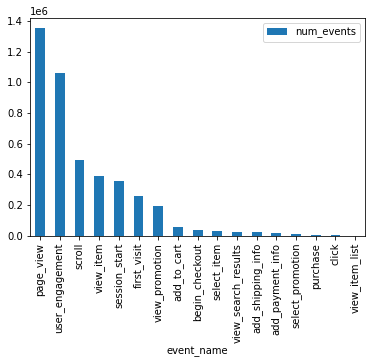

In [24]:
event_name_counts_sql = '''
    SELECT
      event_name,
      COUNT(*) AS num_events

    FROM
      `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`

    GROUP BY
      event_name

    ORDER BY
      num_events DESC
    '''

event_name_counts = bq_query(event_name_counts_sql)

# matplotlib used to create basic bar plot
event_name_counts_bar_plot = event_name_counts.plot(
    kind="bar", x="event_name", y="num_events")

event_name_counts_bar_plot

You can see from the bar plot that page views and user engagements are the two most common event types, with a large drop-off to the other types of events.

You can display the same event type distribution data in an interactive bar plot using Plotly Express.

In [25]:
event_name_counts_interactive_bar_plot = px.bar(
    event_name_counts,
    x="event_name",
    y="num_events",
    title="Number of Events by event_name"
    )

event_name_counts_interactive_bar_plot.show()

The bar plot shows the same info as the previous one, with the additional feature of interactivity. You can hover over each bar to see the actual number of events or zoom in to various parts of the chart (e.g. to see how the numbers for the less common events compare on a smaller scale).

### Function to generalize event counts bar plot creation
Suppose that you like the previous interactive bar plot of event counts, and want to look at it for other categorical variables in the data like those related to device, user characteristics, or other fields. A nice to way generalize this is to create a function that gets event counts data from BigQuery for any single variable and then creates an interactive bar plot like the one above. Run the following cell to create such a function.

In [26]:
def get_event_counts_by_categorical_var_bar_plot(bq_var_name, output_var_name,
                                                 min_events=500):
    
    # SQL code "template" to get event counts for specific variable in data
    event_counts_sql = f'''
        SELECT
          IFNULL({bq_var_name}, 'NULL') AS {output_var_name},
          COUNT(*) AS num_events

        FROM
          `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`

        GROUP BY
          {bq_var_name}
        
        /* Filter to only return values of variable that have some min. # of
           events - default is 500, can set to 0 to do no filtering */
        HAVING
          num_events >= {min_events}
        
        ORDER BY
          num_events DESC
        '''

    event_counts = bq_query(event_counts_sql)
    
    # Take results from SQL query and turn into bar plot for given variable
    event_counts_interactive_bar_plot = px.bar(
        event_counts,
        x=output_var_name,
        y="num_events",
        title=(f"<b>Number of Events by {output_var_name}<br></b>" + 
               f"Min. {min_events} Events for {output_var_name}")
        )
    
    return(event_counts_interactive_bar_plot)


;

''

### Number of events by country, operating system, and device language
Here, you use the function created above to get event counts by three different categorical variables in the data: country, operating system, and device language. These are displayed in three separate tabs of the same output cell below, using the [tab functionality from the ipywidgets package](https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20List.html#Tabs).

In [27]:
# Create table of categorical variables (BQ and output names) to loop over
categorical_vars_df = pd.DataFrame.from_records(
    data=[
      ('geo.country', 'country'),
      ('device.operating_system', 'operating_system'),
      ('device.language', 'device_language')
      ], 
    columns=['bq_var_name', 'output_var_name']
    )

# Initialize tab outputs list to be appended to
tab_outputs = []

# Loop over categorical variables data, generating 1 bar plot per tab
for index, row in categorical_vars_df.iterrows():
    this_tab = widgets.Output()
    
    with this_tab:
        get_event_counts_by_categorical_var_bar_plot(
            row['bq_var_name'], row['output_var_name']
            ).show()
    
    # Append tab output for this tab to list of outputs
    tab_outputs = tab_outputs + [this_tab]

# Create output with all tab outputs together
output = widgets.Tab(tab_outputs)
  
# Loop over categorical variables again to set output tab titles
for index, row in categorical_vars_df.iterrows():
    output.set_title(index, row['output_var_name'])
    
display(output)

Clicking through the tabs, you can see that:

*   The United States is the country with the most events, followed by India and the United Kingdom.
*   "Web" is the most common device operating system by far, with iOS and Windows pretty close for second. 
*   The most common value in the device language field is actually NULL, or no data in the field. This is important to note in any sort of further analysis or modeling using language. You may want to understand why it's missing, what types of users/events have missing language more or less often, and how that may/may not change in future data.

### Interactive: pick category, get corresponding event counts bar plot
Building on the previous section, you can go even further with interactivity and allow picking from a set of categories present in the data, then dynamically creating the plot for whichever variable is selected. Below you create an interactive list of device attributes and slider for minimum number of events, then pass those on to the function to create the interactive event counts plot with those parameters. Each time you change one of the parameters, the code will run again to create the new plot accordingly.

(NOTE: You must be running this notebook in a "live" kernel to use the interactive menus in the cell below. It won't work if you're just looking at previously generated output in the notebook.)

In [28]:
# Filter to categorical fields that are nested under device (to use as options)
device_cat_vars = (info_schema_column_field_paths[
    (info_schema_column_field_paths['column_name'] == 'device') &
    (info_schema_column_field_paths['data_type'] == 'STRING')
    ].
    reset_index(drop=True)
    )

# Some string manipulation to make device-related variable names
device_cat_vars['var_name'] = [
    ('device_' + field_path.split(".")[-1])
    for field_path in device_cat_vars['field_path']
    ]

# Interact section that creates a function that responds to user input
@interact
def show_device_field_event_counts(
    # Widget to select single variable to look at event counts for
    device_field=widgets.Select(
        options=device_cat_vars['var_name'].tolist(), 
        value='device_category',
        description='Device Attributes',
        continuous_update=False
        ),
    # Slider to pick min. # of events required to return data for given category
    min_num_events=widgets.IntSlider(
        value=500,
        min=0,
        max=1E5,
        step=100,
        description='Min Num Events',
        continuous_update=False
        )):

    clear_output()
        
    # Get BQ variable name for selected device field using data frame
    bq_var_name = device_cat_vars.loc[
        device_cat_vars['var_name'] == device_field, 'field_path'].item()
    
    # Use function to generate event counts bar plot for chosen device field
    event_count_plot = get_event_counts_by_categorical_var_bar_plot(
        bq_var_name, device_field, min_num_events)
    
    return(event_count_plot.show())

interactive(children=(Select(description='Device Attributes', options=('device_category', 'device_mobile_brand…

Feel free to pick different combinations for the widgets in the cell above and see the resulting plots. If you leave the defaults (device_category and 500-event minimum), for example, you'll see that desktop is the most common device category, followed by mobile, and then tablet representing a much smaller proportion of all events than the other two.

One upside of the interactivity here is that you can look through many plots with relatively quick point-and-click options, without having to write repeated code or pre-determine which things to plot.

### Generate heatmap of event distribution across operating system by country
Building on the analysis from the previous steps, you can also query and plot event distributions by the combination of two categorical variables together. In this case, you focus on the example of the combination of country and operating system (OS), which you looked at the individual event distributions for above. In addition to the raw number of events in each country-OS combination, you also calculate the number as a percentage of *all* events in that country, to see if certain countries seem to have more/less activity on a given OS.

In [29]:
country_os_counts_sql = '''
    SELECT
      geo.country AS country,
      device.operating_system AS os,
      
      COUNT(*) AS num_events,
      
      /* Window aggregate function to country total events (across all OS) */
      SUM(COUNT(*)) OVER (PARTITION BY geo.country)
        AS tot_events_in_country,
      
      /* Look at # of events in country-os combination as % of all events in
        that country,  */
      SAFE_DIVIDE(
        COUNT(*),
        SUM(COUNT(*)) OVER (PARTITION BY geo.country)
        ) * 100 AS pct_events_in_country

    FROM
      `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`

    GROUP BY
      geo.country, device.operating_system
    
    QUALIFY
      tot_events_in_country >= 50000
    
    ORDER BY
      num_events DESC
    '''
        
country_os_counts = bq_query(country_os_counts_sql)

country_os_counts

,country,os,num_events,tot_events_in_country,pct_events_in_country
0,United States,Web,1098875,1910483,57.518177
1,India,Web,232760,391859,59.398916
2,United States,iOS,227321,1910483,11.898614
3,United States,Windows,223270,1910483,11.686573
4,Canada,Web,190921,324261,58.878804
...,...,...,...,...,...
79,South Korea,<Other>,1554,51584,3.012562
80,France,<Other>,1463,82514,1.773032
81,Netherlands,<Other>,1455,50303,2.892472
82,Japan,<Other>,1340,56676,2.364316


One useful visualization for this type of two-category joint distribution data is a heatmap. Below, you create such a visualization of the percentage of events in each country that fall into each device OS, using [Plotly Express' heatmap functionality](https://plotly.com/python/heatmaps/).

In [30]:
# Pivot country-OS data to get in form necessary for Plotly Express heat map
country_os_counts_matrix = pd.pivot_table(
    country_os_counts, 
    values='pct_events_in_country', 
    index=['os'],
    columns=['country'], 
    aggfunc=np.sum
    )

# Create heat map % of events in each country (columns) by device OS (rows)
country_os_counts_heatmap = px.imshow(
    country_os_counts_matrix,
    labels=dict(x="Country", y="Device OS",
                color="% Events in Country on This OS"),
    title="Percent of Events in Each Country by Device OS"
    )

country_os_counts_heatmap.show()

From looking at the colors and hovering over some of the numbers, it's clear that the distribution of events across device OS doesn't look very different across countries. Web is the dominant OS in every country, accounting for 55-65% of events in each country analyzed here. There are some other systems with slightly higher proportions in some countries (e.g. Windows in France, iOS in Singapore), but you likely come away from the heatmap thinking how relatively consistent things look across countries.

## Analyze correlation between user-level aggregate metrics
In this section, you look at the event data at the user level.All events that correspond to the same user_pseudo_id get grouped together, and then you perform analysis on the users' activity (instead of individual events, as in the previous section).

### Calculate and explore user-level aggregate metrics
First, you use BigQuery to generate some interesting aggregates at the user level: page views, user engagements, and total purchase value (sales).

In [31]:
%%bigquery user_aggregates --project $PROJECT_ID
  SELECT
    user_pseudo_id,
    
    /* Use array functionality to get most recent language by user
       (in case of >1 language per user, which is possible) */
    IFNULL((ARRAY_AGG(device.language ORDER BY event_timestamp DESC)
      [SAFE_ORDINAL(1)]), 'NULL') 
      AS language,
    
    SUM(IF(event_name = 'page_view', 1, 0))
      AS num_page_views,
    
    SUM(IF(event_name = 'user_engagement', 1, 0))
      AS num_user_engagements,
    
    SUM(IF(event_name = 'purchase', event_value_in_usd, 0))
      AS tot_purchase_value_usd

  FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`

  GROUP BY
    user_pseudo_id
    
  ORDER BY
    tot_purchase_value_usd DESC, num_page_views DESC

Downloading: 100%|██████████| 270154/270154 [00:02<00:00, 127861.24rows/s]


In [32]:
user_aggregates

,user_pseudo_id,language,num_page_views,num_user_engagements,tot_purchase_value_usd
0,81036435.1157569602,NULL,191,181,1530.0
1,15046526.4562004600,NULL,52,48,1424.0
2,8083450.3844124226,NULL,219,204,1404.0
3,60695124.4742262801,NULL,160,146,1260.0
4,7134559299.4601048201,en-gb,32,31,1200.0
...,...,...,...,...,...
270149,5617634.5410303461,zh,0,1,0.0
270150,1269147.4663343073,de,0,1,0.0
270151,25386248.0371916728,en-us,0,1,0.0
270152,7031008.4333209145,en-us,0,2,0.0


Looking at the user aggregates output, you can see there are ~270K distinct users in the sample GA4 data, with the highest spenders purchasing items that total more than $1400 from the online store.

You can now explore this user data further using [Plotly's scatter plot functionality](https://plotly.com/python/line-and-scatter/) to look at engagements vs page views in an interactive plot. The code below does that, while also sizing points by total purchase value and coloring them by user device language.

In [ ]:
user_page_views_engagements_scatter_plot = px.scatter(
    user_aggregates,
    x='num_page_views',
    y='num_user_engagements',
    size='tot_purchase_value_usd',
    color='language',
    title=('<b>User-Level Engagements vs Page Views</b><br>' +
           '(Each Point is 1 User, Sized by Total Purchase Value)')
    ) 

user_page_views_engagements_scatter_plot.show()

There's a lot you can see by playing around with this interactive plot, including:

*   There's an extremely strong positive correlation between user page views and engagements, which makes sense logically.
*   Users with higher page views and engagements generally seem to have higher total purchase values, though you can see users with more money spent toward the bottom left and users spending relatively less toward the top right. 
*   With few exceptions, the most active users (high on both page views and engagements) are those with "en-us" as their language or (more commonly) no known device language. You know from before that those are the two most common values in the lanaguage field across all events, so perhaps this is consistent with that and relatively unsurprising. 

### Examine correlations between user-level metrics
You saw the some of the correlations among user page views, engagements, and purchase value in the above plot. Next, you calculate the actual correlation values among these quantities across users.

In [33]:
user_aggregates.corr()

,num_page_views,num_user_engagements,tot_purchase_value_usd
num_page_views,1.000000,0.984337,0.380772
num_user_engagements,0.984337,1.000000,0.381475
tot_purchase_value_usd,0.380772,0.381475,1.000000


The correlation between user page views and engagements is extremely high (0.98), as expected, while the correlations between each of those and purchase value is positive but much more modest (0.38).

Going beyond the overall correlation, you might want to understand if these relationships are similar across different slices of your data - user demographics, for example. In the query below, you calculate the correlation between each of page views and engagements with purchase value, but this time _by country_, using [BigQuery's built-in correlation functionality](https://cloud.google.com/bigquery/docs/reference/standard-sql/statistical_aggregate_functions#corr).

In [34]:
%%bigquery user_purchase_value_correlations_by_country --project $PROJECT_ID 
/* Use structure of user_aggregates query from above in WITH clause, as first 
   step to aggregate data to user level */
WITH
user_aggregates AS
(
  SELECT
    user_pseudo_id,

    /* Use array functionality to get most recent country by user
       (in case of >1 country per user, which is possible) */
    IFNULL((ARRAY_AGG(geo.country ORDER BY event_timestamp DESC)
      [SAFE_ORDINAL(1)]), 'Unknown') 
      AS country,
    
    SUM(IF(event_name = 'page_view', 1, 0))
      AS num_page_views,
    
    SUM(IF(event_name = 'user_engagement', 1, 0))
      AS num_user_engagements,
    
    SUM(IF(event_name = 'purchase', event_value_in_usd, 0))
      AS tot_purchase_value_usd

  FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`

  GROUP BY
    user_pseudo_id
)

SELECT
  country,
  COUNT(*) AS num_users,
  CORR(num_page_views, tot_purchase_value_usd)
    AS corr_page_views_purchase_value,
  
  CORR(num_user_engagements, tot_purchase_value_usd)
    AS corr_engagements_purchase_value

FROM
  user_aggregates

GROUP BY
  country

/* Only return countries w/ 500+ users (for higher sample size) */
HAVING
  num_users >= 500    
    
ORDER BY
  num_users DESC

Downloading: 100%|██████████| 47/47 [00:01<00:00, 27.28rows/s]


With the data read in from BigQuery, you can now display it in an interactive table (with some formatting to avoid having to read really long decimal columns).

In [35]:
with pd.option_context("display.float_format", "{:,.3f}".format):
    show(user_purchase_value_correlations_by_country)

Loading... (need help?)


From sorting the interactive table on the correlation columns in both directions, you can see that the correlations between the user activity metrics and purchase value do differ across countries. Some countries like Greece and Colombia have correlations greater than 0.6, while others like Belgium and Italy have correlations less than 0.25. This says something about how the translation from customer site activity to sales varies in different places around the world - a topic with potential for deeper study and implications for how you might go about modeling purchase behavior.

## Time series analysis of purchases by date and time
Another common exploratory data analysis pattern is to look at certain metrics across time. There is an entire field - and a [powerful set of Google Cloud tools](https://cloud.google.com/learn/what-is-time-series) - devoted to time series forecasting, but in this case you'll focus on more fundamental exploration of the sample GA4 data aggregated by date and/or time fields.

### Create template query to aggregate purchase value across date and time

You want to analyze purchase data across time - first, aggregated to the date level, and then also across hours of the day. One way to do this without repeating code is to write a SQL query template like the one below, which aggregates to the date level and provides the option to enter in text corresponding to an hour field (which is also added to the grouping for aggregation). 

In this example, you want to focus on United States data only to simplify the issues with dates across the world meaning different things based on time zones. To enable this, the code below filters to only US events and moves all events to their date/time in US Pacific Time ([the event_timestamp field in Google Analytics data is in UTC](https://support.google.com/analytics/answer/7029846?hl=en#:~:text=of%20your%20app\).-,event_timestamp,-INTEGER)) to match what is generally day/night in the country.

In [36]:
purchases_by_date_hour_sql_template = '''
    WITH
    USDateAggregates AS
    (
      SELECT
        /* Use event_timestamp and move things to date in US (Pacific Time) */
        EXTRACT(DATE FROM TIMESTAMP_MICROS(event_timestamp) 
          AT TIME ZONE "America/Los_Angeles") AS event_date,

        /* Add template field for hour of day, can use to aggregrate or split */
        {hour_of_day_sql} AS hour_of_day,        

        COUNT(*) AS num_purchases,
        SUM(event_value_in_usd) AS total_purchase_value

      FROM 
        `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`

      WHERE
        /* Filter to US data only */
        geo.country = 'United States' AND
        /* Look only at purchases with non-NULL values */
        event_name = 'purchase' AND
        event_value_in_usd IS NOT NULL

      GROUP BY
        event_date, hour_of_day
    )

    SELECT
      event_date,
      hour_of_day,

      /* Extract various date-related fields from event date */
      EXTRACT(YEAR FROM event_date) AS year,
      EXTRACT(MONTH FROM event_date) AS month,
      EXTRACT(DAY FROM event_date) AS day,

      EXTRACT(WEEK FROM event_date) AS week_of_year_num,
      EXTRACT(ISOWEEK FROM event_date) AS iso_week,

      EXTRACT(DAYOFWEEK FROM event_date) AS day_of_week_num,
      FORMAT_DATE("%A", event_date) AS day_of_week,

      EXTRACT(DAYOFYEAR FROM event_date) AS day_of_year,

      num_purchases,
      total_purchase_value,

      SAFE_DIVIDE(
        total_purchase_value,
        num_purchases
        ) AS avg_purchase_value

    FROM
      USDateAggregates

    ORDER BY
      event_date, hour_of_day
    '''
;

''

### Look at total purchase value by date

First, you look at purchase aggregates by date across the three months in the Google Analytics data.

In [37]:
# Run query with 'ALL' (string) for hour of day to aggregate all hours together
purchases_by_date = bq_query(purchases_by_date_hour_sql_template.format(
    hour_of_day_sql="'ALL'"))

You can plot the daily purchase sales in an interactive time series plot using [Plotly's line plot functionality](https://plotly.com/python/line-charts/).

In [38]:
total_purchase_value_by_date_plot = px.line(
    purchases_by_date,
    x='event_date', 
    y='total_purchase_value',
    # Add day of week to hover data to help read off interactive plot
    hover_data=['event_date', 'day_of_week', 'total_purchase_value'],
    title='<b>United States Total Purchase Value (USD) by Date<b>'
    )

total_purchase_value_by_date_plot.show()

A few things you can see from this plot:

*   There's the expected US retail industry pattern of a positive trend in sales throughout November, a relatively high level of sales during the pre-Christmas shopping season (through mid-December), and then a dramatic drop off leading into the end-of-year holidays that mostly persists through January.
*   There is substantial variance in total sales from day to day. At the extremes, the day with the highest sales in the period is ["Cyber Monday"](https://en.wikipedia.org/wiki/Cyber_Monday) and the day with the lowest sales (among days for which there is full data) is Christmas - both of which are relatively unsurprising. 
*   There appear to be some day-of-week effects like Mondays being relatively high in sales and weekends being relatively low.

### Look at total purchase value by day of week and time of day
Next, you go further by gathering total purchase data on both the date and hour of day level - a finer level of aggregation than above - and using a heatmap to study common purchase patterns.

In [39]:
# Run query with string corresponding to hour of day (in US Pacific Time)
purchases_by_date_hour = bq_query(purchases_by_date_hour_sql_template.format(
    hour_of_day_sql=("EXTRACT(HOUR FROM TIMESTAMP_MICROS(event_timestamp)" +
                     "AT TIME ZONE 'America/Los_Angeles')")
    )
)

To get a heatmap in the desired "week timeline" form, you further aggregate to the day-of-week and hour-of-day level while pivoting to the right format. Each cell in the heatmap represents the total US sales for a given hour on the given day of the week across all dates in the three months of data (e.g. the top left represents sales across all Sundays from 12-1am Pacific Time).

In [40]:
# Add day of week field combining number and name, to help with sorting on plot
purchases_by_date_hour['day_of_week_combo'] = (
    purchases_by_date_hour['day_of_week_num'].astype('str') + ' - ' + 
    purchases_by_date_hour['day_of_week']
    )

# Pivot to day-of-week/hour-of-day grid, summing purchase value while doing so
purchases_by_dayofweek_hourofday_matrix = pd.pivot_table(
    purchases_by_date_hour, 
    values='total_purchase_value', 
    index=['day_of_week_combo'],
    columns=['hour_of_day'], 
    aggfunc=np.sum
    )

purchases_by_dayofweek_hourofday_heatmap = px.imshow(
    purchases_by_dayofweek_hourofday_matrix,
    labels=dict(x="Hour of Day", y="Day of Week", color="Total Purchase Value"),
    title=("<b>United States Total Purchase Value (USD) by Day & Hour (PDT)<b>")
    )

purchases_by_dayofweek_hourofday_heatmap.show()

A few things you can see from this plot:

*   There is substantial variance in total sales across days and hours. At the extremes, there are day/hour combinations with more than $\$$2,000 in sales and others with less than $\$$100 in sales over this time period.
*   As you saw in the daily sales plot, Saturday and Sunday are relatively low in sales (with the possible exception of late Sunday), while Monday is relatively high (with different peaks throughout the day). Times that correspond to the middle of the night across most of the country (0-5 on the x-axis) are generally slow on most days, with some outliers.

Some of the things you see in the plot above don't totally fit with what you'd expect based on time zones, so it may be worth checking for outlier (high) purchase values that could've skewed the data in some of the day/hour combinations.

## Save some outputs to Cloud Storage
Sometimes you may want some of your code output - tables, graphs, etc. - to persist outside of your notebook. This could be to preserve some results for when you're done with the notebook or to share with various collaborators via other mediums.

In this section, you'll take some of the outputs generated earlier and save them outside of the notebooks in three different ways:
*   a table to a CSV file
*   an interactive plot to an HTML file
*   an interactive plot to a (static) PNG file

First, you save the table of user-level correlations by country as a CSV. Initially, this will save the CSV file in the local notebook environment.

In [41]:
user_country_correlations_output_name = "user_level_correlations_by_country.csv"

user_purchase_value_correlations_by_country.to_csv(
    user_country_correlations_output_name)

Next, you save the interactive bar plot of event counts by name as an HTML file using [Plotly's HTML export capabilities](https://plotly.com/python/interactive-html-export/).

In [42]:
event_name_counts_output_name = "event_name_counts_interactive_bar_plot.html"

event_name_counts_interactive_bar_plot.write_html(event_name_counts_output_name)

While interactive plots can be powerful, there are often cases where you need to convert your interactive into a static plot to fit certain constraints or simplify things for readers. In this case, you save the heatmap of purchase by day and hour as a static PNG file using [Plotly's static image export functionality](https://plotly.com/python/static-image-export/). This uses the [kaleido library](https://github.com/plotly/Kaleido) "under the hood" to convert the interactive plot to a static one.

In [43]:
purchases_day_hour_output_name = "purchases_by_dayofweek_hourofday_heatmap.png"

purchases_by_dayofweek_hourofday_heatmap.write_image(
    purchases_day_hour_output_name)

Finally, you take the three different output files in the local notebook environment and copy them to your specified Cloud Storage bucket.

In [44]:
for output_file_name in [
    user_country_correlations_output_name,
    event_name_counts_output_name,
    purchases_day_hour_output_name
    ]:
    
    ! gsutil cp $output_file_name $BUCKET_URI

Copying file://user_level_correlations_by_country.csv [Content-Type=text/csv]...
/ [1 files][  2.6 KiB/  2.6 KiB]                                                
Operation completed over 1 objects/2.6 KiB.                                      
Copying file://event_name_counts_interactive_bar_plot.html [Content-Type=text/html]...
-
Operation completed over 1 objects/3.5 MiB.                                      
Copying file://purchases_by_dayofweek_hourofday_heatmap.png [Content-Type=image/png]...
/ [1 files][ 42.5 KiB/ 42.5 KiB]                                                
Operation completed over 1 objects/42.5 KiB.                                     


## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the Cloud Storage bucket that you created in this tutorial if you'd like:

In [45]:
# Delete Cloud Storage bucket that was created
if os.getenv("IS_TESTING"):
    ! gsutil -m rm -r $BUCKET_URI